<a href="https://colab.research.google.com/github/Koosmaster/Tutorial-Automatic-Modulation-Classification/blob/main/Automatic_Modulation_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial: RF Signal Classification Using Deep Learning Models for Modulation Recognition**

##### __by Markus Parrish__
##### updated: 2025-09-25
<br>

##### This project presents the development and evaluation of machine learning models for identification of radio frequency (RF) signals by focusing on Automatic Modulation Classification (AMC). The tutorial presents baseline models will include k-Nearest Neighbors (kNN), Support Vector Machines (SVM), and Random Forests. Deep learning methods will include Convolutional Neural Networks (CNNs), Recurrent Neural Networks (RNNs), and combinations of the prior. The dataset will be RadioML 2016.01A to enable a comparison across Signal-To-Noise Ratio (SNR) levels. It will provide reproducible code and highlight the limitations and benefits of each method.
<br>

---
---
## Setup
---

In [ ]:
# GPU Check
print("Torch CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


Torch CUDA available: True
CUDA device: Tesla T4


## Libraries

In [ ]:
# For access to datasets saved on google drive
from google.colab import drive
drive.mount('/content/drive')

# Libraries
## Code below from haozheng61
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pickle
import os


from pathlib import Path
ROOT = Path("/content/AMC")
DATA = ROOT / "data"
RAW  = DATA / "raw"
PROC = DATA / "processed"
for p in [DATA, RAW, PROC]:
    p.mkdir(parents=True, exist_ok=True)
DATASETS_PATH = Path("/content/drive/MyDrive/AMC_matlab_dataset.pkl")
print(DATASETS_PATH.exists()) # Test that google drive is mounted
import pickle
with open(DATASETS_PATH, "rb") as f:
    data = pickle.load(f, encoding='latin1')
type(data), len(data)
print(type(data))

Mounted at /content/drive
True
<class 'dict'>


In [ ]:
import numpy as np

def summarize_obj(name, obj, max_items=5):
    import numpy as np
    if isinstance(obj, np.ndarray):
        print(f"- {name}: ndarray shape={obj.shape} dtype={obj.dtype}")
    elif isinstance(obj, (list, tuple)):
        n = len(obj)
        head = obj[:min(n, max_items)]
        t = type(head[0]).__name__ if n else "empty"
        print(f"- {name}: {type(obj).__name__} len={n} first={t}")
    elif isinstance(obj, dict):
        print(f"- {name}: dict keys={list(obj.keys())[:10]}")
    else:
        print(f"- {name}: {type(obj).__name__}")

print("Top-level keys:", list(data.keys()))
#for k, v in data.items():
   # summarize_obj(k, v)


Top-level keys: [('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('8PSK', 8), ('8PSK', 12), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('PAM4', -6), ('WBFM', -18), ('AM-DSB', 16), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('AM-SSB', 6), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('AM-SSB', -12), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('BPSK', -10), ('QPSK', 8), ('PAM4', 14), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('WBFM', -4), ('AM-SSB', -18), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('8PSK', -8), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('AM-SSB', 8), ('GFSK', 18), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('AM-SSB', -2), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('AM-SSB', 2), ('WBFM', 10), ('AM-DSB', -12), 

In [ ]:
import numpy as np

# data is your loaded dict
# Keys look like: ('QPSK', 2), ('AM-DSB', -4), ...
mods = sorted({k[0] for k in data.keys()})
label_to_idx = {m:i for i,m in enumerate(mods)}
idx_to_label = {i:m for m,i in label_to_idx.items()}

X_list, y_list, snr_list = [], [], []
for (mod, snr), arr in data.items():
    # arr shape is (N, 2, 128)  -> convert to (N, 128, 2) so each sample is [T, 2]
    X_list.append(np.transpose(arr, (0, 2, 1)).astype(np.float32))
    y_list.append(np.full(arr.shape[0], label_to_idx[mod], dtype=np.int64))
    snr_list.append(np.full(arr.shape[0], snr, dtype=np.int32))

X = np.concatenate(X_list, axis=0)          # (N, 128, 2)
y = np.concatenate(y_list, axis=0)          # (N,)
snr = np.concatenate(snr_list, axis=0)      # (N,)

N, T, C = X.shape
print(f"N={N}, sample shape={T}x{C}, num_classes={len(mods)}")
print("Classes:", mods[:10], "…")


N=220000, sample shape=128x2, num_classes=11
Classes: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK'] …


In [ ]:
rng = np.random.default_rng(1337)  # <- fixed seed

# stratify by (y, snr)
keys = np.stack([y, snr], axis=1)
uniq, inv = np.unique(keys, axis=0, return_inverse=True)

train_idx, val_idx, test_idx = [], [], []
for k in range(len(uniq)):
    idx = np.where(inv == k)[0]
    rng.shuffle(idx)
    n = len(idx)
    n_train = int(0.70*n)
    n_val   = int(0.15*n)
    train_idx.extend(idx[:n_train])
    val_idx.extend(idx[n_train:n_train+n_val])
    test_idx.extend(idx[n_train+n_val:])

train_idx = np.array(train_idx); val_idx = np.array(val_idx); test_idx = np.array(test_idx)
len(train_idx), len(val_idx), len(test_idx)


(154000, 33000, 33000)

SVM test accuracy: 0.4633859590191468


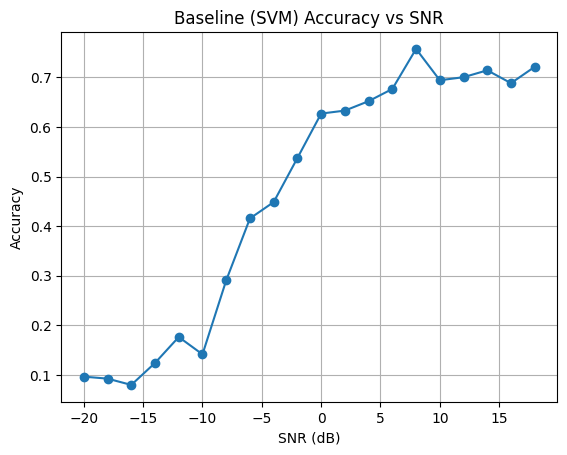

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def extract_features_batch(X_batch, n_bands=16):
    # X_batch: (B, T, 2) -> complex, FFT power, pool into bands + simple stats
    feats = []
    for x in X_batch:
        z = x[:,0] + 1j*x[:,1]
        F = np.fft.fftshift(np.fft.fft(z))
        p = (np.abs(F)**2).astype(np.float32)
        bands = np.array_split(p, n_bands)
        band_means = np.array([b.mean() for b in bands], dtype=np.float32)
        stats = np.array([x[:,0].mean(), x[:,1].mean(), x[:,0].std(), x[:,1].std()], dtype=np.float32)
        feats.append(np.concatenate([band_means, stats]))
    return np.stack(feats)

# Build features for a manageable subset for speed (adjust up later)
sub = min(40000, N)   # try 40k samples; lower if RAM is tight
sel = np.random.RandomState(0).choice(N, size=sub, replace=False)

Xf = extract_features_batch(X[sel])
ys = y[sel]
snr_s = snr[sel]

trm = np.isin(sel, train_idx); vam = np.isin(sel, val_idx); tem = np.isin(sel, test_idx)
Xtr, Xva, Xte = Xf[trm], Xf[vam], Xf[tem]
ytr, yva, yte = ys[trm], ys[vam], ys[tem]
snr_te = snr_s[tem]

scaler = StandardScaler().fit(Xtr)
Xtr_s, Xva_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xva), scaler.transform(Xte)

clf = SVC(kernel="rbf", gamma="scale", C=10)
clf.fit(Xtr_s, ytr)
yhat = clf.predict(Xte_s)
print("SVM test accuracy:", accuracy_score(yte, yhat))

# Accuracy vs SNR curve
bins = np.unique(snr_te)
accs = [(yhat[snr_te==b] == yte[snr_te==b]).mean() for b in bins]
plt.figure()
plt.plot(bins, accs, marker="o")
plt.xlabel("SNR (dB)"); plt.ylabel("Accuracy"); plt.title("Baseline (SVM) Accuracy vs SNR"); plt.grid(True); plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
FR 10%
FR 20%
FR 30%
FR 40%
FR 50%
FR 60%
FR 70%
FR 80%
FR 90%
FR 100%
(7000, 22, 256)
(3000, 22, 256)
FR complete
----------------------------------------------------------------------------------------------------
Training data: (7000, 22, 256, 2)
Training labels: (7000, 11)
Testing data (3000, 22, 256, 2)
Testing labels (3000, 11)
----------------------------------------------------------------------------------------------------


Model: "SCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 22, 256,   │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 22, 260,   │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_10   │ (None, 24, 256,   │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 11, 253,   │      2,772 │ zero_padding2d_9… │
│                     │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 11, 253,   │      2,772 │ zero_padding2d_1… │
│                     │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 11, 253,   │          0 │ conv2d_33[0][0]   │
│ (Activation)        │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 11, 253,   │          0 │ conv2d_34[0][0]   │
│ (Activation)        │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 253,   │        336 │ activation_39[0]… │
│ (BatchNormalizatio… │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 253,   │        336 │ activation_40[0]… │
│ (BatchNormalizatio… │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 11, 253,   │          0 │ batch_normalizat… │
│ (Concatenate)       │ 168)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_11   │ (None, 11, 256,   │          0 │ concatenate_9[0]… │
│ (ZeroPadding2D)     │ 168)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 11, 256,   │    112,980 │ zero_padding2d_1… │
│                     │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 11, 256,   │     84,756 │ zero_padding2d_1… │
│                     │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_41       │ (None, 11, 256,   │          0 │ conv2d_35[0][0]   │
│ (Activation)        │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_42       │ (None, 11, 256,   │          0 │ conv2d_36[0][0]   │
│ (Activation)        │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 256,   │        336 │ activation_41[0]… │
│ (BatchNormalizatio… │ 84)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 256,   │        336 │ activation_42[0]

 Total params: 18,483,187 (70.51 MB)

 Trainable params: 18,482,179 (70.50 MB)

 Non-trainable params: 1,008 (3.94 KB)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.0909 - loss: 6.2361 - val_accuracy: 0.1013 - val_loss: 2.3979 - learning_rate: 5.0000e-04
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.0914 - loss: 2.3977 - val_accuracy: 0.1013 - val_loss: 2.3979 - learning_rate: 5.0000e-04
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1061 - loss: 2.3952 - val_accuracy: 0.1427 - val_loss: 2.3973 - learning_rate: 5.0000e-04
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1398 - loss: 2.3723 - val_accuracy: 0.0980 - val_loss: 2.3963 - learning_rate: 5.0000e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1358 - loss: 2.3288 - val_accuracy: 0.1007 - val_loss: 2.3964 - learning_rate: 5.0000e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1434 - loss: 2.3087 - val_accuracy: 0.1007 - val_loss: 2.3939 - learning_rate: 5.0000e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1717 

[3.811469793319702, 2.3976707458496094, 2.3943657875061035, 2.3667643070220947, 2.3288402557373047, 2.302053689956665, 2.2716867923736572, 2.246746301651001, 2.2107837200164795, 2.2029831409454346, 2.1736319065093994, 2.175523281097412, 2.1433773040771484, 2.144536018371582, 2.1106948852539062, 2.087407350540161, 2.0498180389404297, 2.025270700454712, 1.981444001197815, 1.9640909433364868, 1.9530956745147705, 1.955891728401184, 1.963533878326416, 1.9312533140182495, 1.8979395627975464, 1.890800952911377, 1.9098129272460938, 1.940516471862793, 1.8808807134628296, 1.8501346111297607, 1.8559727668762207, 1.855529546737671, 1.86724054813385, 1.8315813541412354, 1.820670247077942, 1.821252465248108, 1.8211557865142822, 1.8173737525939941, 1.8196187019348145, 1.81248140335083, 1.8077037334442139, 1.8138190507888794, 1.8099384307861328, 1.8111209869384766, 1.8130109310150146, 1.8057459592819214, 1.8176385164260864, 1.8163467645645142, 1.8055377006530762, 1.8175939321517944, 1.8118984699249268

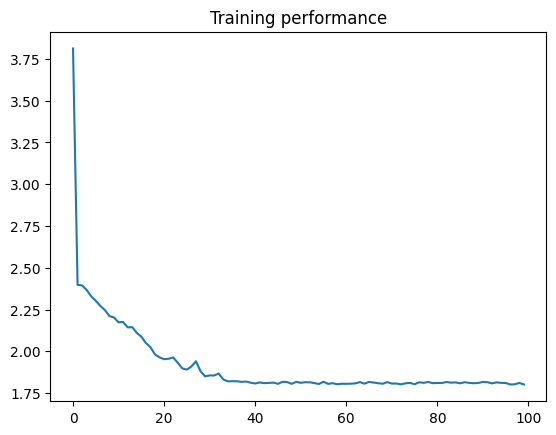

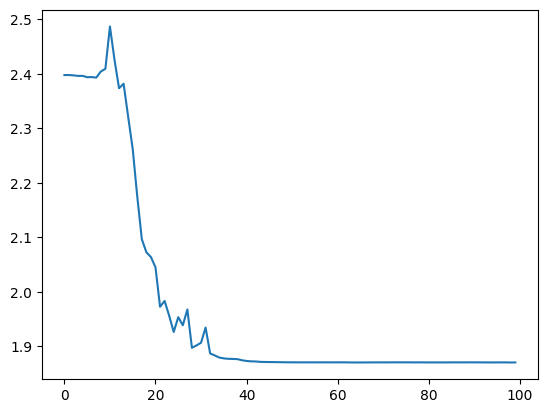

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step


/tmp/ipython-input-3328508575.py:377: RuntimeWarning: invalid value encountered in divide
  confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])


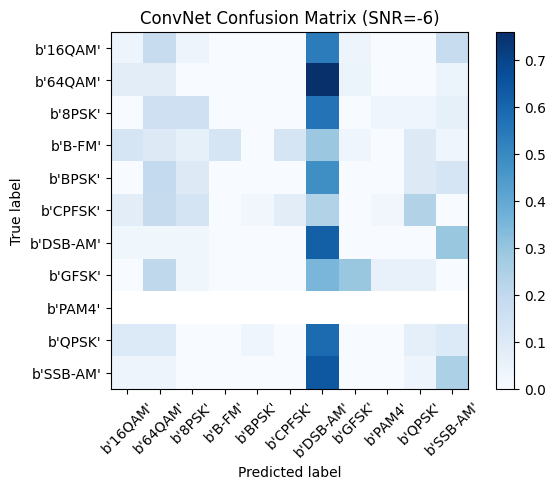

snr: -6
acc: 0.1774193548387097
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step


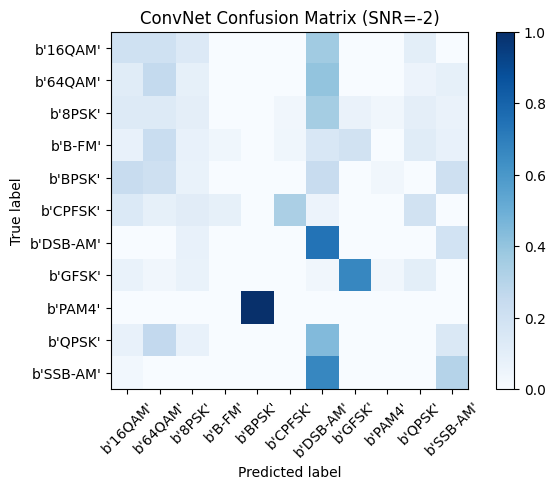

snr: -2
acc: 0.26557377049180325
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step


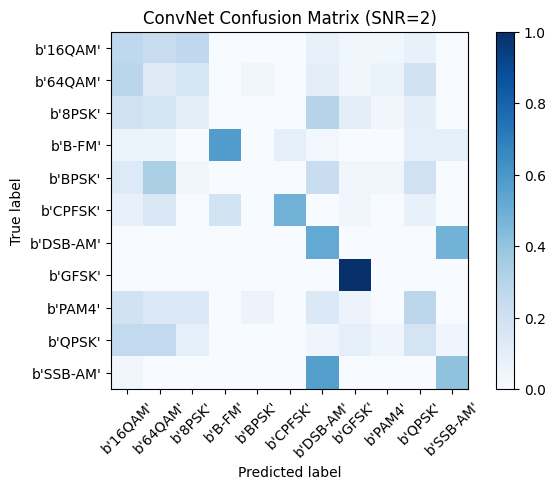

snr: 2
acc: 0.2627986348122867
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step


/tmp/ipython-input-3328508575.py:377: RuntimeWarning: invalid value encountered in divide
  confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])


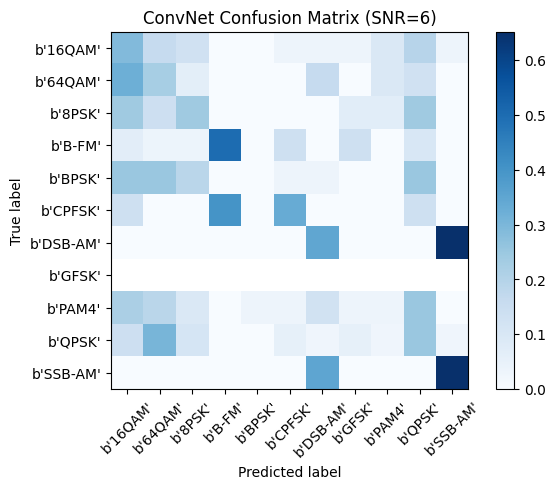

snr: 6
acc: 0.2687074829931973
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step


/tmp/ipython-input-3328508575.py:377: RuntimeWarning: invalid value encountered in divide
  confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])


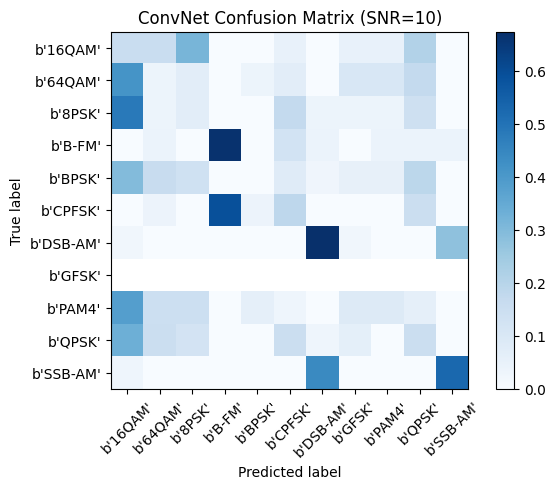

snr: 10
acc: 0.26537216828478966
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step


/tmp/ipython-input-3328508575.py:377: RuntimeWarning: invalid value encountered in divide
  confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])


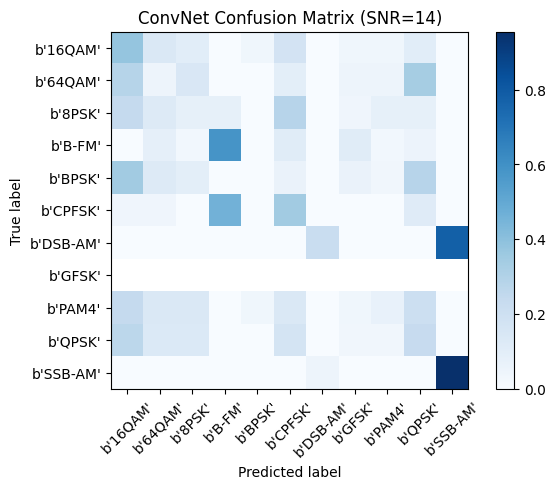

snr: 14
acc: 0.2867132867132867
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step


/tmp/ipython-input-3328508575.py:377: RuntimeWarning: invalid value encountered in divide
  confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])


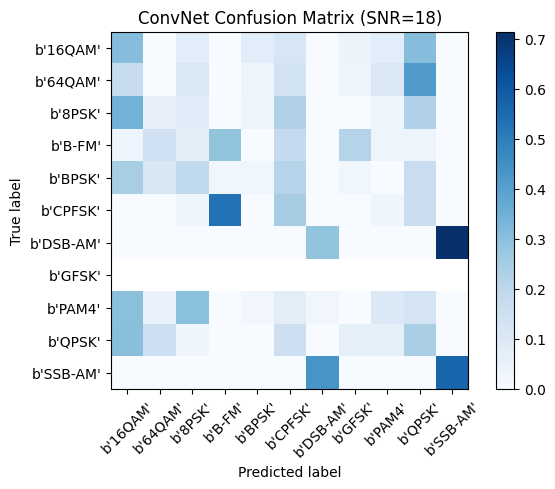

snr: 18
acc: 0.19407894736842105
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/tmp/ipython-input-3328508575.py:377: RuntimeWarning: invalid value encountered in divide
  confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])


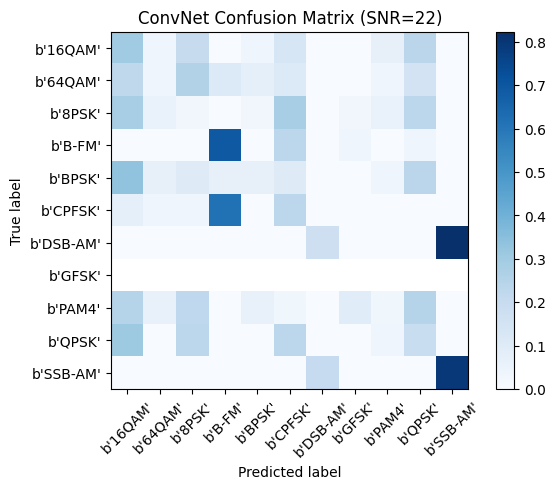

snr: 22
acc: 0.26229508196721313
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step


/tmp/ipython-input-3328508575.py:377: RuntimeWarning: invalid value encountered in divide
  confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])


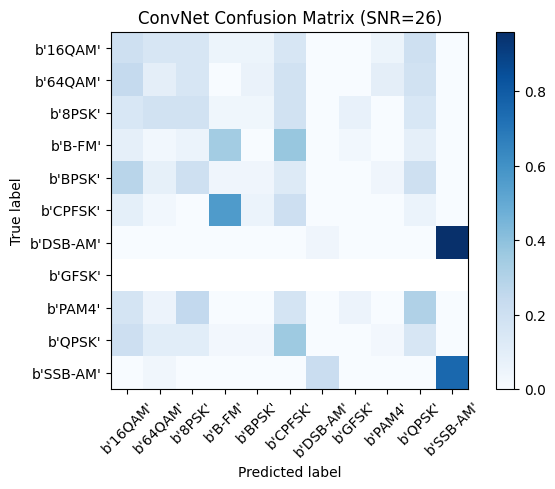

snr: 26
acc: 0.20588235294117646
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/tmp/ipython-input-3328508575.py:377: RuntimeWarning: invalid value encountered in divide
  confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])


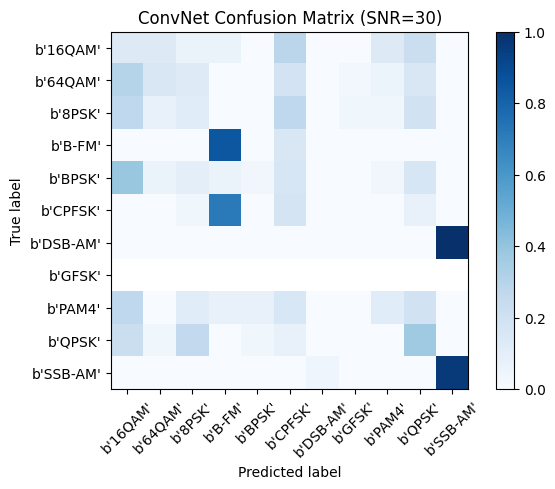

snr: 30
acc: 0.2847222222222222


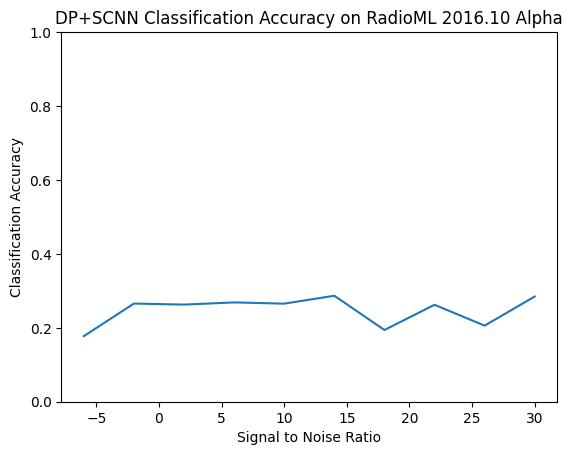

In [22]:

from google.colab import drive
drive.mount('/content/drive')

import numpy as np

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import pickle


import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

snrs = ""
mods = ""
test_idx = ""
lbl = ""
ttrate = 0.7


def gendata(fp):
    global snrs, mods, test_idx, lbl
    Xd = pickle.load(open(fp, 'rb'), encoding='bytes')
    snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])
    X = []
    lbl = []

    for mod in mods:
        for snr in snrs:
            X.append(Xd[(mod, snr)])
            for i in range(Xd[(mod, snr)].shape[0]):
                lbl.append((mod, snr))
    X = np.vstack(X)

    np.random.seed(2019)
    n_examples = X.shape[0]
    n_train = int(n_examples * ttrate)
    train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)
    test_idx = list(set(range(0, n_examples)) - set(train_idx))
    X_train = X[train_idx]
    X_test = X[test_idx]

    def to_onehot(yy):
        yy1 = np.zeros([len(yy), max(yy) + 1])
        yy1[np.arange(len(yy)), yy] = 1
        return yy1

    Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
    Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

    return (X_train, X_test, Y_train, Y_test)

def FeatureReverse(a,step):
    def Reverse(a,s):
        b = a
        i = 1
        while (1):
            p = i * (i + 1) * s / 2
            p = int(p)
            b = np.r_[b, np.c_[a[:, (len(a[0]) - p):], a[:, :(len(a[0]) - p)]]]
            i = i + 1
            if p + (i + 1) * s > len(a[0]):
                break
        return b
    ab = np.array([])
    for i in range(a.shape[0]):
        ab = np.append(ab,Reverse(a[i],step))
    ab = np.array(ab).reshape((a.shape[0], int(ab.shape[0]/(a.shape[0]*a.shape[2])), a.shape[2]))
    return ab

xtrain1, xtest1, ytrain1, ytest1 = gendata("/content/drive/MyDrive/AMC_matlab_dataset.pkl")

Rstep = 4
trainbatch = int(xtrain1.shape[0]/1000)   #Distributed processing to effectively increase computing speed
testbatch = int(xtest1.shape[0]/1000)
x_train1 = FeatureReverse(xtrain1[:trainbatch],Rstep)
x_test1 = FeatureReverse(xtest1[:testbatch],Rstep)
for i in range(99):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[(i+1)*trainbatch:(i+2)*trainbatch],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[(i+1)*testbatch:(i+2)*testbatch],Rstep)]
print('FR 10%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100:(i+1)*trainbatch+trainbatch*100],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100:(i+1)*testbatch+testbatch*100],Rstep)]
print('FR 20%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*2:(i+1)*trainbatch+trainbatch*100*2],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*2:(i+1)*testbatch+testbatch*100*2],Rstep)]
print('FR 30%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*3:(i+1)*trainbatch+trainbatch*100*3],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*3:(i+1)*testbatch+testbatch*100*3],Rstep)]
print('FR 40%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*4:(i+1)*trainbatch+trainbatch*100*4],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*4:(i+1)*testbatch+testbatch*100*4],Rstep)]
print('FR 50%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*5:(i+1)*trainbatch+trainbatch*100*5],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*5:(i+1)*testbatch+testbatch*100*5],Rstep)]
print('FR 60%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*6:(i+1)*trainbatch+trainbatch*100*6],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*6:(i+1)*testbatch+testbatch*100*6],Rstep)]
print('FR 70%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*7:(i+1)*trainbatch+trainbatch*100*7],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*7:(i+1)*testbatch+testbatch*100*7],Rstep)]
print('FR 80%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*8:(i+1)*trainbatch+trainbatch*100*8],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*8:(i+1)*testbatch+testbatch*100*8],Rstep)]
print('FR 90%')
for i in range(100):
    x_train1 = np.r_[x_train1,FeatureReverse(xtrain1[i*trainbatch+trainbatch*100*9:(i+1)*trainbatch+trainbatch*100*9],Rstep)]
    x_test1 = np.r_[x_test1,FeatureReverse(xtest1[i*testbatch+testbatch*100*9:(i+1)*testbatch+testbatch*100*9],Rstep)]
print('FR 100%')
print(x_train1.shape)
print(x_test1.shape)
print('FR complete')

from numpy import linalg as la
def amp_phase(a):
    b = np.zeros(a.shape)
    n = int(a.shape[1]/2)
    for i in range(n):
        x_tran = a[:,i*2,:] + 1j*a[:,i*2+1,:]
        b[:,i*2,:] = np.abs(x_tran)
        b[:,i*2+1,:] = np.arctan2(a[:,i*2,:], a[:,i*2+1,:]) / np.pi
    return b
def norm(a,b):
    for i in range(a.shape[0]):
        norm_amp = 1 / la.norm(a[i, 0, :], 2)
        b[i,:,:] = b[i,:,:] * norm_amp
        for j in range(int(a.shape[1]/2)):
            a[i,j*2,:] = a[i,j*2,:] * norm_amp
    return  a,b
x_train1a = amp_phase(x_train1)
x_test1a = amp_phase(x_test1)
x_train1a,x_train1 = norm(x_train1a,x_train1)
x_test1a,x_test1 = norm(x_test1a,x_test1)
x_train1 = x_train1.reshape(x_train1.shape[0],x_train1.shape[1],x_train1.shape[2],1)
x_train1a = x_train1a.reshape(x_train1a.shape[0],x_train1a.shape[1],x_train1a.shape[2],1)
x_test1 = x_test1.reshape(x_test1.shape[0],x_test1.shape[1],x_test1.shape[2],1)
x_test1a = x_test1a.reshape(x_test1a.shape[0],x_test1a.shape[1],x_test1a.shape[2],1)

xtrain = np.concatenate((x_train1,x_train1a),axis=3)
xtest = np.concatenate((x_test1,x_test1a),axis=3)

def channeltrans(a):
    b = np.zeros(a.shape)
    for i in range(int(a.shape[1]/2)):
        b[:,i*2:i*2+2,:,:] = np.swapaxes(a[:,i*2:i*2+2,:,:],1,3)
    return b

x_train1 = channeltrans(xtrain)
x_test1 = channeltrans(xtest)

X_train = x_train1
X_test = x_test1

Y_train = ytrain1[:X_train.shape[0]]
Y_test = ytest1[:X_test.shape[0]]
test_idx = test_idx[:X_test.shape[0]]

NB_CLASSES=len(Y_train[0])

print("--" * 50)
print("Training data:", X_train.shape)
print("Training labels:", Y_train.shape)
print("Testing data", X_test.shape)
print("Testing labels", Y_test.shape)
print("--" * 50)


def getFontColor(value):
    if np.isnan(value):
        return "black"
    elif value < 0.2:
        return "black"
    else:
        return "white"

def getConfusionMatrixPlot(true_labels, predicted_labels):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm, 2)
    print(cm)

    # create figure
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    res = ax.imshow(cm, cmap=plt.cm.binary,
                    interpolation='nearest', vmin=0, vmax=1)

    # add color bar
    plt.colorbar(res)

    # annotate confusion entries
    width = len(cm)
    height = len(cm[0])

    for x in range(width):
        for y in range(height):
            ax.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',
                        verticalalignment='center', color=getFontColor(cm[x][y]))

    # add genres as ticks
    alphabet = mods
    plt.xticks(range(width), alphabet[:width], rotation=30)
    plt.yticks(range(height), alphabet[:height])
    return plt


from keras import layers
from keras import Sequential, layers
from keras.layers import Reshape, Conv2D, Dense, Activation, Dropout, Flatten, ZeroPadding2D
from keras import optimizers
from keras import models
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, ZeroPadding2D, GlobalAveragePooling2D, Activation, Average, \
    Dropout, GaussianNoise, LSTM, GlobalMaxPooling2D, Add, BatchNormalization, Concatenate
from keras import Model
from keras import regularizers

reduce_lr = ReduceLROnPlateau(monitor='loss', patience=3, mode='auto', factor=0.01)
adam0 = optimizers.Adam(learning_rate=0.0005)

in_shp=X_train.shape[1:]

from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import *

def SCNN(input_shape, classes):
    x_input = Input(input_shape)
    x1 = ZeroPadding2D(padding=((0, 0), (0, 4)))(x_input)
    x1 = Conv2D(84, (2, 8), strides=(2, 1), padding='valid')(x1)
    x1 = Activation('relu')(x1)
    x1 = BatchNormalization()(x1)
    x2 = ZeroPadding2D(padding=((0, 2), (0, 0)))(x_input)
    x2 = Conv2D(84, (4, 4), strides=(2, 1), padding='valid')(x2)
    x2 = Activation('relu')(x2)
    x2 = BatchNormalization()(x2)
    x = Concatenate(axis=3)([x1, x2])
    x = ZeroPadding2D(padding=((0, 0), (0, 3)))(x)
    def Res_block(y):
        shortcut_unit = y
        y1 = Conv2D(84, (1, 8), padding='same')(y)
        y1 = Activation('relu')(y1)
        y1 = BatchNormalization()(y1)
        y1 = Dropout(0.5)(y1)
        y2 = Conv2D(84, (2, 3), padding='same')(y)
        y2 = Activation('relu')(y2)
        y2 = BatchNormalization()(y2)
        y2 = Dropout(0.5)(y2)
        y = Concatenate(axis=3)([y1, y2])
        y = Add()([shortcut_unit, y])
        return y
    x = Res_block(x)
    x = Res_block(x)
    x = Conv2D(168, (2, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(168, (1, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(256, (2, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (2, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(512, (1, 3), padding='same')(x)
    x = Dropout(0.5)(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = GaussianNoise(0.01)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(classes)(x)
    x_out = Activation('softmax')(x)
    model = Model(inputs=x_input, outputs=x_out, name='SCNN')
    return model

def CNN2(input_shape, classes):
    x_input = Input(input_shape)
    x = Conv2D(256,(4,4) , strides= (2,1) , padding='valid')(x_input)
    x = Activation('relu')(x)
    x = Conv2D(256,(3,3) , padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.6)(x)
    x = Conv2D(80,(3,3) , padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(80,(3,3) , padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.6)(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(classes)(x)
    x_out = Activation('softmax')(x)
    model = Model(inputs=x_input, outputs=x_out, name='CNN2')
    return model

model = SCNN(in_shp, NB_CLASSES)
# model = CNN2(in_shp, NB_CLASSES)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=adam0, metrics=['accuracy'])

batch_size = 256
epochs = 100
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=[reduce_lr]
                    )
#model.save('D:\\DPM+SCNN.h5')
model.save('/content/drive/MyDrive/DPM_SCNN.h5')
# model.save('D:\\DPM+CNN2.h5')
print(history.history['loss'])
print('')
print(history.history['val_loss'])
plt.figure()
plt.title('Training performance')
plt.plot(history.history['loss'], label='train loss+error')
plt.show()
plt.plot(history.history['val_loss'], label='val_error')
plt.show()
acc = {}


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_SNRs = list(test_SNRs)
    test_X_i = X_test[np.where(np.array(test_SNRs) == snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)

    conf = np.zeros([len(mods), len(mods)])
    confnorm = np.zeros([len(mods), len(mods)])
    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
    for i in range(0, len(mods)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])

    plot_confusion_matrix(confnorm, labels=mods, title="ConvNet Confusion Matrix (SNR=%d)" % (snr))
    plt.show()

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor

    acc[snr] = 1.0 * cor / (cor + ncor)
    print('snr:', snr)
    print('acc:', acc[snr])

plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("DP+SCNN Classification Accuracy on RadioML 2016.10 Alpha")
# plt.title("DP+CNN2 Classification Accuracy on RadioML 2016.10 Alpha")
plt.yticks(np.linspace(0, 1, 6))
plt.show()